In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

import sys
sys.path.insert(0, '../Modules/')
sys.path.insert(0, '../Shared code/')

import pose_estimation as pe  # noqa (ignore PEP 8 style)
from gait_metrics import gait_dataframe  # noqa
from peakdet import peakdet  # noqa
from general import mad_outliers

# %% Read DataFrame

directory = '../../../MEGA/Data/Kinect Zeno/Kinect processed'
file_name = '2014-12-22_P007_Pre_004.pkl'

load_path = os.path.join(directory, file_name)
df = pd.read_pickle(load_path)


# %% Parameters

lower_part_types = ['HEAD', 'HIP', 'UPPER_LEG', 'KNEE', 'LOWER_LEG', 'FOOT']


lengths = [62.1080, 20.1733, 14.1756, 19.4509, 20.4996]

radii = [i for i in range(0, 30, 5)]

edges = np.matrix('0 1; 1 2; 2 3; 3 4; 4 5; 3 5; 1 3')


# %% Select positions

# Find the best positions for each image frame
best_pos_series = df.apply(lambda x: pe.process_frame(x.to_dict(),
                           lower_part_types, edges, lengths, radii), axis=1)

n_frames = len(df)
for f in range(n_frames):
    row = df.loc[f]

    pe.process_frame(row.to_dict(), lower_part_types, edges, lengths, radii)


# %% Extract head and foot positions

# Each row i is a tuple containing the best positions for frame i
# Split each tuple into columns of a DataFrame
df_best_pos = pd.DataFrame(best_pos_series.values.tolist(),
                           columns=['Side A', 'Side B'])

df_best_pos = df_best_pos.dropna()

# Extract the head and feet positions
head_pos = df_best_pos['Side A'].apply(lambda row: row[0, :])
L_foot_pos = df_best_pos['Side A'].apply(lambda row: row[-1, :])
R_foot_pos = df_best_pos['Side B'].apply(lambda row: row[-1, :])

# Combine into new DataFrame
df_head_feet = pd.concat([head_pos, L_foot_pos, R_foot_pos], axis=1)
df_head_feet.columns = ['HEAD', 'L_FOOT', 'R_FOOT']
df_head_feet.index.name = 'Frame'


# %% Remove outlier frames

y_foot_L = df_head_feet.apply(lambda row: row['L_FOOT'][1], axis=1).values
y_foot_R = df_head_feet.apply(lambda row: row['R_FOOT'][1], axis=1).values

y_foot_L_filtered = mad_outliers(y_foot_L, 2)
y_foot_R_filtered = mad_outliers(y_foot_R, 2)

good_frame_L = ~np.isnan(y_foot_L_filtered)
good_frame_R = ~np.isnan(y_foot_R_filtered)

df_head_feet = df_head_feet[good_frame_L & good_frame_R]


# %% Gait metrics


foot_dist = df_head_feet.apply(lambda row: np.linalg.norm(
                               row['L_FOOT'] - row['R_FOOT']), axis=1)


h


In [3]:
# Cluster frames with k means to locate the 4 walking passes

frames = foot_dist.index.values.reshape(-1, 1)

k_means = KMeans(n_clusters=4, random_state=0).fit(frames)

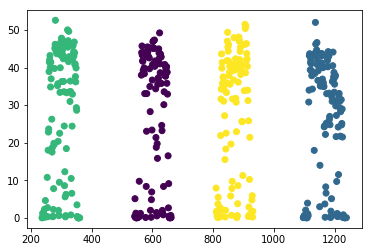

In [4]:
foot_dist_points = foot_dist.reset_index().values
frame_labels = k_means.labels_
plt.scatter(foot_dist_points[:, 0], foot_dist_points[:, 1], c=frame_labels)

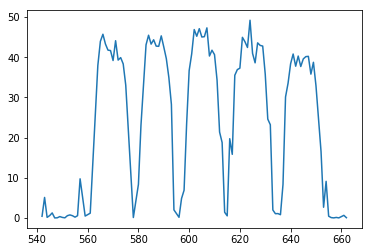

In [5]:
plt.plot(foot_dist[frame_labels == 0])

In [6]:
from general import root_mean_square

rms = root_mean_square(foot_dist.values)

In [7]:
is_upper_value = foot_dist > rms
upper_foot_dist = foot_dist[is_upper_value]
upper_frame_labels = frame_labels[is_upper_value]
upper_foot_dist_points = foot_dist_points[is_upper_value]

cluster_0 = upper_foot_dist_points[upper_frame_labels == 0]

In [8]:
from clustering import mean_shift, flat_kernel_shift, gaussian_kernel_shift

labels, centroids, k = mean_shift(cluster_0[:,0].reshape(-1,1), flat_kernel_shift, radius=40)

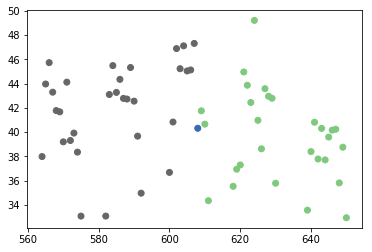

In [9]:
plt.scatter(cluster_0[:,0], cluster_0[:,1], c=labels, cmap='Accent')

In [154]:
from general import centre_of_mass

def kernel_shift(points, mean_pos, radius):
    
    print(mean_pos)
    
    x = points[:, 0].reshape(-1)
    
    distances = abs(x - mean_pos[0])
    
    within_radius = distances <= radius
        
    points_in_radius = points[within_radius, 0].reshape(-1, 1)
    masses = points[within_radius, 1]

    centre = centre_of_mass(points_in_radius, masses)
    
    return [centre]

In [282]:
def weighted_kernel_shift(points, mean_pos, radius, masses):
    
    G = partial(gaussian, mu=0, sigma=radius)
    
    distances = points - mean_pos

    adjusted_masses = G(distances) * masses

    return centre_of_mass(points, adjusted_masses)
    

In [216]:
from functools import partial

points = cluster_0[:, 0].reshape(-1, 1)
masses = cluster_0[:, 1].reshape(-1, 1)

f = partial(weighted_shift_func, masses=masses)

In [226]:
labels, centroids, k = mean_shift(points, f, radius=20)

In [254]:
%matplotlib auto
plt.scatter(cluster_0[:,0], cluster_0[:,1], c=labels, cmap='Accent')

Using matplotlib backend: MacOSX


In [343]:
from general import gaussian, centre_of_mass
points = cluster_0[:, 0].reshape(-1, 1)
masses = cluster_0[:, 1].reshape(-1, 1)

eps = 0.01
radius = 5

n_points, n_dimensions = points.shape
index_matrix = np.full((n_points, n_points), False)
all_centroids = np.full((n_points, n_dimensions), np.nan)

for i, mean_pos in enumerate(points):

    K = partial(gaussian, mu=0, sigma=radius)

    while True:
        
        prev_mean_pos = mean_pos

        distances = points - mean_pos
        adjusted_masses = K(distances) * masses
        
        mean_pos = centre_of_mass(points, adjusted_masses)
        
        if np.linalg.norm(prev_mean_pos - mean_pos) < eps:
            
            distances = np.linalg.norm(points - mean_pos, axis=1)
            in_radius = distances <= radius
            break
    
    all_centroids[i, :] = mean_pos
    index_matrix[i, :] = in_radius


In [344]:
 _, unique_indices, labels = np.unique(index_matrix,
                                          return_index=True, return_inverse=True, axis=0)

centroids = all_centroids[unique_indices, :]
k, _ = centroids.shape

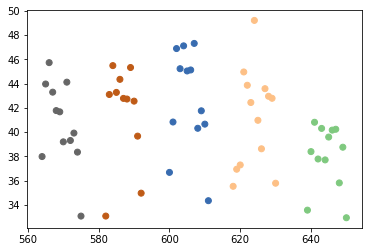

In [348]:
%matplotlib inline
plt.scatter(cluster_0[:,0], cluster_0[:,1], c=labels, cmap='Accent')

In [379]:
def weighted_shift(points, mean_pos, radius, masses):
    """
    Special function that uses a gaussian kernel and 
    a list of masses to find the centre of mass
    """ 
    distances = points - mean_pos
    
    K = partial(gaussian, mu=0, sigma=radius)
    adjusted_masses = K(distances) * masses
    
    return centre_of_mass(points, adjusted_masses)

frames = cluster_0[:, 0].reshape(-1, 1)
values = cluster_0[:, 1].reshape(-1, 1)

shift_func = partial(weighted_shift, masses=values)



In [11]:
labels, centroids, k = mean_shift(frames, gaussian_kernel_shift, radius=5, eps=0.01)

ValueError: c of shape (467,) not acceptable as a color sequence for x with size 60, y with size 60

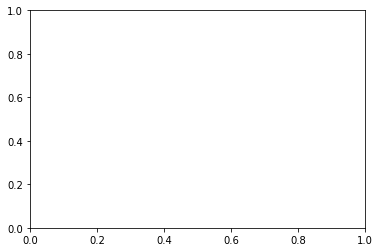

In [12]:
plt.scatter(cluster_0[:,0], cluster_0[:,1], c=labels, cmap='Accent')

In [1]:
centroids

NameError: name 'centroids' is not defined